In [4]:
#setup
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Project Introduction
The big idea of our project is to  Explore the correlation between gun violence cases with age, location, and/or socioeconomic factors in the area. One main question that we are investigating is has gun reform impacted the number of gun violence cases in the US? We have multiple datasets that show gun-related cases by state and year, firearm laws passed by states, and state populations. The scope of our project is to visualize the number of gun cases in the US using the Gun Violence dataset from the Gun Violence Archive.


# Any Changes
A discussion whether your scope has changed since the check-in proposal slides. What did you aim to do that you will not do and what have you added to the project?

# Data Cleaning
Show clearly how you cleaned your data

# Exploratory Data Analysis
Explain what your data looks like (words are fine, but visualizations are often better). Include any interesting issues or preliminary conclusions you have about your data.

# At least one visualization that tests an interesting hypothesis


The hypothesis that we will be testing is that states with more strict gun laws have a smaller amount of gun violence incidents compared to states with less strict gun laws.

In [1]:
# Reading in data for gun violence counts and firearm laws
gun_data = pd.read_csv('gun-violence-data_01-2013_03-2018.csv')
missing_row = ['sban_1', '2017-10-01', 'Nevada', 'Las Vegas', 'Mandalay Bay 3950 Blvd S', 59, 489, 'https://en.wikipedia.org/wiki/2017_Las_Vegas_shooting', 'https://en.wikipedia.org/wiki/2017_Las_Vegas_shooting', '-', '-', '-', '-', '-', '36.095', 'Hotel', 
               '-115.171667', 47, 'Route 91 Harvest Festiva; concert, open fire from 32nd floor. 47 guns seized; TOTAL:59 kill, 489 inj, number shot TBD,girlfriend Marilou Danley POI', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-']
gun_data.loc[len(gun_data)] = missing_row

gunlaws = pd.read_csv('statefirearmlaws.csv')
gun_laws = pd.DataFrame(data = gunlaws,columns=['state', 'year', 'lawtotal'])


df_state = gun_data.groupby(['state']).size().reset_index(name='counts')
df_state = df_state.sort_values(by='counts', ascending=False)
sns.set(rc = {'figure.figsize':(10,8)})
sns.barplot(x='counts', y='state', data=df_state, palette='viridis').set(title="Gun Violence Count by State");

df_state.head()

NameError: name 'pd' is not defined

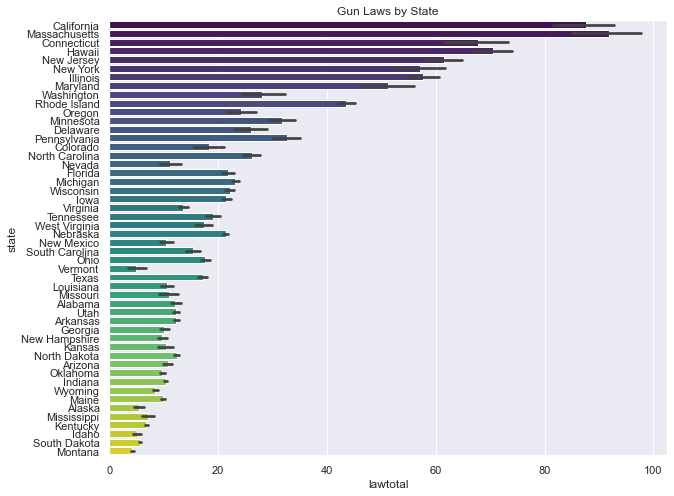

In [81]:
df_laws = gun_laws.sort_values(by='lawtotal', ascending=False)
sns.set(rc = {'figure.figsize':(10,8)})
sns.barplot(x='lawtotal', y='state', data=df_laws, palette='viridis').set(title="Gun Laws by State");

Looking at the visualizations, Illinois has the highest gun violence incidents and Hawaii has the least number of incidents. However, the population difference is very large. Because of this, we will calculate a proportion that represents (# of cases/ population). 


In [142]:
uspopulation = pd.read_csv('us_states_census.csv') 
population = pd.DataFrame(data=uspopulation, columns=['state','2013','2014','2015','2016','2017', '2018'])

state_cases = gun_data.groupby(['state']).size().reset_index(name='counts')
state_cases = state_cases.sort_values(by='state', ascending=True)
state_cases['population'] = population['2018']

prop_cases = population
prop_cases['prop_cases'] = state_cases['counts'] / population['2018']
prop_cases = prop_cases.sort_values(by=['prop_cases'], ascending=False)
print(prop_cases.head(2))
print(prop_cases.tail(1))

                  state      2013      2014      2015      2016      2017  \
8  District of Columbia  650581.0  662328.0  675400.0  685815.0  694906.0   
1                Alaska  737068.0  736283.0  737498.0  741456.0  739700.0   

       2018  prop_cases  
8  701547.0    0.004554  
1  735139.0    0.001835  
     state       2013       2014       2015       2016       2017       2018  \
11  Hawaii  1408243.0  1414538.0  1422052.0  1427559.0  1424393.0  1420593.0   

    prop_cases  
11    0.000203  


Looking at the new proportion calculations, we will compare the proportion of cases between District of Columbia and Hawaii and if the number of laws affects the proportion.


[Text(0.5, 1.0, 'Proportion of cases by population in 2018')]

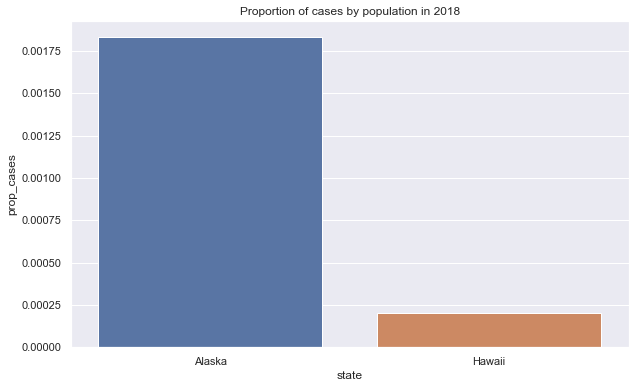

In [140]:
top_state_inc = pd.DataFrame(population[population['state'] == 'Alaska'])
low_state_inc = pd.DataFrame(population[population['state'] =='Hawaii'])

list_states_inc = [top_state_inc, low_state_inc]
stats_inc = pd.concat(list_states_inc)
stats_inc
sns.set(rc = {'figure.figsize':(10,6)})
sns.barplot(data=stats_inc, x="state", y="prop_cases").set(title="Proportion of cases by population in 2018")


In Alaska, roughly 3 laws were passed each year between 2013 and 2018, and the proportion of cases by population is 0.001835. In Hawaii, roughly 79-80 laws were added by 2018. There is a lower proportion, 0.000203. 

# Hypothesis Results

Our hypothesis is correct. Alaska has one of the  highest proportions of gun-related incidents by population, but a lower number of gun laws. Hawaii has a lower proportion of gun-related incidents by population, and a higher number of gun laws passes. Given that our hypothesis was that states with low gun-reated incidents have higher gun laws, and vice versa, our hypothesis was correct. 

# At least on ML analysis
on your dataset, along with a baseline comparison and an interpretation of the result that you obtain. 

# Reflection
A discussion of the following:
- What is the hardest part of the project that you’ve encountered so far?
- What are your initial insights?
- Are there any concrete results you can show at this point? If not, why not?
- Going forward, what are the current biggest problems you’re facing?
- Do you think you are on track with your project? If not, what parts do you need to dedicate more time to?
- Given your initial exploration of the data, is it worth proceeding with your project, why? If not, how are you going to change your project and why do you think it’s better than your current results?

# Next Steps
What you plan to accomplish in the next month and how you plan to evaluate whether your project achieved the goals you set for it. 

## Deliverables: a PDF of your jupyter notebook, with a link to the notebook located in your repository; Notebook can’t be more than 5 pages